# SleepDB Dataset Creation
In this notebook, we create TS for the TSSB from the SleepDB data archive.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import daproli as dp

import pandas as pd

pd.set_option('display.max_rows', None)

import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import sys
import mne
import os

sys.path.append("../../")

from tqdm import tqdm
from src.profile_visualization import plot_ts

First, we need to download the mHealth data archive from https://physionet.org/content/sleep-edfx/1.0.0/ and place it into the DATA_PATH folder.

In [3]:
DATA_PATH = "../../archives/SleepDB/"

Now, we define a helper procedure to extract change points from a series of activities.

In [4]:
def extract_cps(activities):
    cps = list()

    for idx in range(1, len(activities)):
        if activities[idx - 1] != activities[idx]:
            cps.append(idx)

    return np.array(cps, dtype=np.int64)

Let's write the function to load the request time series with annotated change points.

In [5]:
def load_sleep_ts(signal, annotation, resample_rate=1):
    df = []

    rec = mne.io.read_raw_edf(DATA_PATH + "sleep-telemetry/" + signal + ".edf")
    ann = mne.read_annotations(DATA_PATH + "sleep-telemetry/" + annotation + ".edf")

    cps, desc = [], []

    for cp, stage in zip(ann.onset, ann.description):
        if stage == "Sleep stage ?":
            continue

        cps.append(cp)
        desc.append(stage)

    cps = np.asarray(cps, dtype=np.int64)[extract_cps(desc)]
    cps = cps * 100

    for idx, sensor in enumerate(rec.ch_names):
        if sensor == "Marker": continue

        name = f"SleepDB Subject{signal} {sensor}"
        ts = rec.get_data()[idx, :]
        df.append((name.replace(" ", "_"), cps, ts))

    return pd.DataFrame.from_records(df, columns=["name", "change_points", "time_series"])

Now, let's load the subject data and explore it.

In [6]:
df = load_sleep_ts("ST7011J0-PSG", "ST7011JP-Hypnogram")

Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

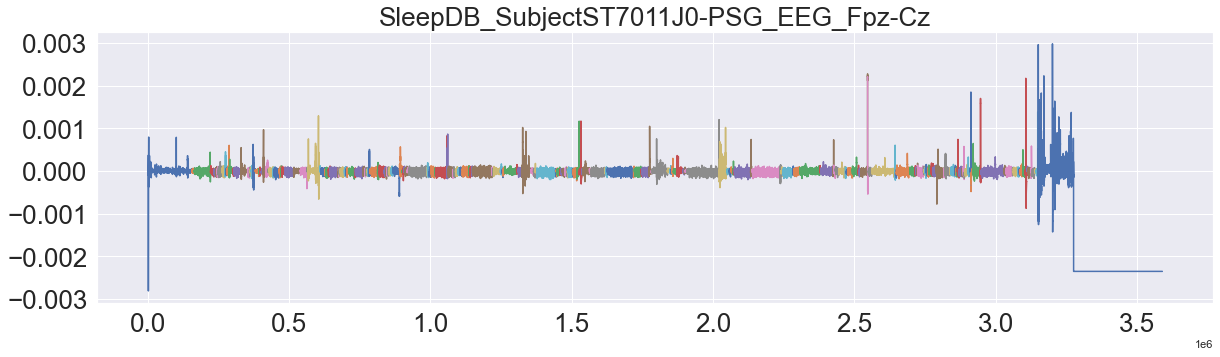

(3590000,)


In [7]:
selection = 0

name, cps, ts = df.iloc[selection, :].tolist()

plot_ts(
    name,
    ts,
    cps,
    show=True
)

print(ts.shape)

Finally, let's save the TS dataset.

In [8]:
DATASET_PATH = "../../datasets/SleepDB/"

In [9]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [10]:
records = pd.read_csv("https://physionet.org/files/sleep-edfx/1.0.0/RECORDS-v1", header=None)[0].to_numpy()
files = pd.read_csv("https://physionet.org/files/sleep-edfx/1.0.0/SHA256SUMS.txt", delimiter=" ", header=None)[
    1].to_numpy()

desc = []
data = dict()
signal = 1
window_size = 100

import gc

for subject in tqdm(records):
    subject = subject[:6]

    if not subject.startswith("ST"): continue

    subject_files = [f for f in files if subject in f]

    print(subject)

    signal = [s[16:-4] for s in subject_files if s.endswith("PSG.edf")][0]
    annotation = [s[16:-4] for s in subject_files if s.endswith("Hypnogram.edf")][0]

    df = load_sleep_ts(signal, annotation)

    for _, (name, cps, ts) in df.iterrows():
        desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
        data[name] = ts

    gc.collect()

np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)

  0%|                                                    | 0/61 [00:00<?, ?it/s]

ST7011
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|████████████████████████████▏              | 40/61 [00:02<00:01, 19.43it/s]

ST7022
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7022J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
ST7041
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7041J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|█████████████████████████████▌             | 42/61 [00:05<00:03,  5.99it/s]

ST7052
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7052J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████████████████████████████▎            | 43/61 [00:07<00:04,  4.15it/s]

ST7061
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7061J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████████████████████████████            | 44/61 [00:09<00:05,  2.99it/s]

ST7071
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7071J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████████████████████████████▋           | 45/61 [00:10<00:07,  2.22it/s]

ST7082
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7082J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|████████████████████████████████▍          | 46/61 [00:13<00:09,  1.51it/s]

ST7092
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7092J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|█████████████████████████████████▏         | 47/61 [00:15<00:11,  1.17it/s]

ST7101
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7101J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|█████████████████████████████████▊         | 48/61 [00:17<00:13,  1.07s/it]

ST7112
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7112J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|██████████████████████████████████▌        | 49/61 [00:20<00:15,  1.32s/it]

ST7121
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7121J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|███████████████████████████████████▏       | 50/61 [00:22<00:16,  1.51s/it]

ST7132
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7132J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|███████████████████████████████████▉       | 51/61 [00:24<00:15,  1.53s/it]

ST7141
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7141J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████████████████████████████████▋      | 52/61 [00:26<00:15,  1.68s/it]

ST7151
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7151J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|█████████████████████████████████████▎     | 53/61 [00:28<00:15,  1.91s/it]

ST7162
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7162J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|██████████████████████████████████████     | 54/61 [00:30<00:13,  1.87s/it]

ST7171
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7171J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|██████████████████████████████████████▊    | 55/61 [00:32<00:11,  1.91s/it]

ST7182
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7182J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|███████████████████████████████████████▍   | 56/61 [00:34<00:10,  2.00s/it]

ST7192
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7192J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|████████████████████████████████████████▏  | 57/61 [00:37<00:08,  2.03s/it]

ST7201
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7201J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|████████████████████████████████████████▉  | 58/61 [00:38<00:05,  1.94s/it]

ST7212
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7212J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████████████████████████████████████▌ | 59/61 [00:40<00:04,  2.03s/it]

ST7221
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7221J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|██████████████████████████████████████████▎| 60/61 [00:43<00:02,  2.31s/it]

ST7241
Extracting EDF parameters from /Users/ermshaua/Documents/Git/classification-score-stream/archives/SleepDB/sleep-telemetry/ST7241J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|███████████████████████████████████████████| 61/61 [00:45<00:00,  1.33it/s]
